In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
sys.path.append("../scaling")

import yaml

import torch
from torchvision.transforms import v2
from ultralytics import YOLO
from torchinfo import summary

In [3]:
import cv2
import numpy as np
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

# definitions

In [4]:
base_folder = os.path.dirname(os.curdir)
imgsz = 640  # the default on train.py
best_model_path = os.path.join(base_folder, "../runs/segment/yolo11l-seg-300ep/weights/best.pt")
config_file = os.path.join(base_folder, "../water.yaml")

# configuration file
print(f"Reading {config_file}")
with open(config_file, 'r') as file:
    config = yaml.safe_load(file)

Reading ../water.yaml


In [5]:
# load the best YOLO model
yolo_model = YOLO(best_model_path)

dummy_input = torch.rand(size=(1, 3, imgsz, imgsz))
model = yolo_model.model

### Describe layers

In [6]:
summary(model, size=dummy_input.shape)

Layer (type:depth-idx)                                       Param #
SegmentationModel                                            --
├─Sequential: 1-1                                            --
│    └─Conv: 2-1                                             --
│    │    └─Conv2d: 3-1                                      (432)
│    │    └─BatchNorm2d: 3-2                                 (32)
│    │    └─SiLU: 3-3                                        --
│    └─Conv: 2-2                                             --
│    │    └─Conv2d: 3-4                                      (4,608)
│    │    └─BatchNorm2d: 3-5                                 (64)
│    │    └─SiLU: 3-6                                        --
│    └─C3k2: 2-3                                             --
│    │    └─Conv: 3-7                                        (1,088)
│    │    └─Conv: 3-8                                        (3,200)
│    │    └─ModuleList: 3-9                                  (2,352)
│    └─C

## Evaluate model

- check the output structure

In [7]:
model.eval()
outputs = model(dummy_input)
print("outputs:", len(outputs), "entries")
print("outputs[0].shape:", outputs[0].shape)
print("outputs[1]:", len(outputs[1]), "entries")

print("outputs[1][0]     :", len(outputs[1][0]), "entries")
print("- outputs[1][0][0]:", outputs[1][0][0].shape)
print("- outputs[1][0][1]:", outputs[1][0][1].shape)
print("- outputs[1][0][2]:", outputs[1][0][2].shape)

print("outputs[1][1]     :", len(outputs[1][1]), "entries")
print("- outputs[1][1][0]:", outputs[1][1][0].shape)

print("outputs[1][2]     :", len(outputs[1][2]), "entries")
print("- outputs[1][2][0]:", outputs[1][2][0].shape)

outputs: 2 entries
outputs[0].shape: torch.Size([1, 37, 8400])
outputs[1]: 3 entries
outputs[1][0]     : 3 entries
- outputs[1][0][0]: torch.Size([1, 65, 80, 80])
- outputs[1][0][1]: torch.Size([1, 65, 40, 40])
- outputs[1][0][2]: torch.Size([1, 65, 20, 20])
outputs[1][1]     : 1 entries
- outputs[1][1][0]: torch.Size([32, 8400])
outputs[1][2]     : 1 entries
- outputs[1][2][0]: torch.Size([32, 160, 160])


#### List some layer names

In [8]:
for name, param in model.named_parameters():
    if "model.5" in name:
        print(name, param.shape)

model.5.conv.weight torch.Size([128, 128, 3, 3])
model.5.bn.weight torch.Size([128])
model.5.bn.bias torch.Size([128])


In [9]:
print(model.model[0])

Conv(
  (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
  (act): SiLU(inplace=True)
)


In [10]:
model.model[4].cv1.conv

Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)

In [11]:
# print(list(model.named_parameters()))

### Evaluate using a real image

In [12]:
image_path = "/project_antwerp/water-level-kul/data/images/water_v2_-_river_segs_00017.jpg"
image_path = "/project_antwerp/water-level-kul/data/images/water_v2_-_boston_harbor2_small_rois_boston_second_Feb-23-2019-11-03-22.jpg"
image_path = "/project_antwerp/water-level-kul/data/images/water_v2_-_ADE20K_ADE_train_00003136.png"
label_path = image_path.replace("data/images/", "data/labels/")[:-4] + ".txt"

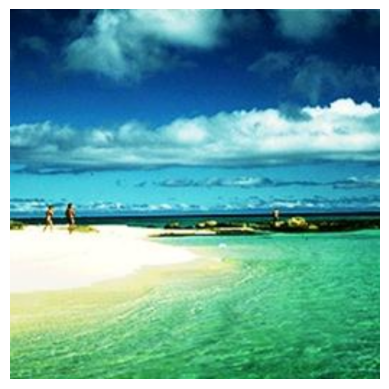

In [13]:
img = np.array(Image.open(image_path))
img = cv2.resize(img, (640, 640))
rgb_img = img.copy()
img = np.float32(img) / 255
transform = transforms.ToTensor()
tensor = transform(img).unsqueeze(0)

plt.imshow(rgb_img)
_ = plt.axis("off")

In [14]:
model.eval()
model.cpu()
output = model(tensor)

In [15]:
# output[0]
tensor[0][0]

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.1686, 0.1804, 0.1843],
        [0.0000, 0.0000, 0.0000,  ..., 0.1608, 0.1725, 0.1765],
        [0.0000, 0.0000, 0.0000,  ..., 0.1294, 0.1412, 0.1451],
        ...,
        [0.2824, 0.2784, 0.2745,  ..., 0.0941, 0.0588, 0.0510],
        [0.2392, 0.2392, 0.2353,  ..., 0.1020, 0.0667, 0.0549],
        [0.2314, 0.2314, 0.2235,  ..., 0.1020, 0.0667, 0.0588]])

In [16]:
from evaluate import decode_yolov11_segmentation, combine_masks, decode_raw_labels
from matplotlib.patches import Polygon

In [17]:
boxes, masks = decode_yolov11_segmentation(output, image_size=list(tensor.shape[2:]))

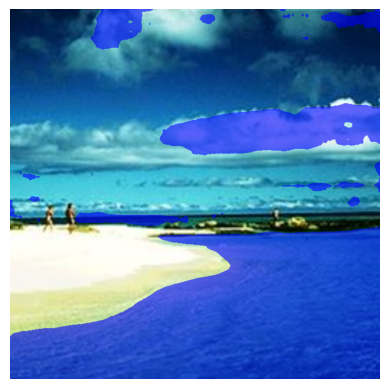

In [18]:
overlay = rgb_img.copy()
mask = combine_masks(masks)
color=(0, 0, 255)
alpha=0.6

color_layer = np.zeros_like(rgb_img)
color_layer[:,:] = color
# Blend the original image and the color layer
overlay[mask] = (1 - alpha) * rgb_img[mask] + alpha * color_layer[mask]

plt.imshow(overlay)
_ = plt.axis("off")

In [19]:
with open(label_path, "r") as f:
    lines = f.read().split("\n")

labels = decode_raw_labels(lines)

In [20]:
from evaluate import resize_polygons
resized_labels = resize_polygons(labels, (640, 640))

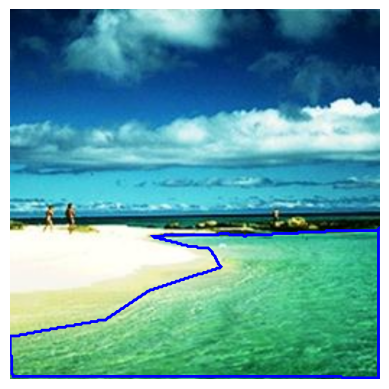

In [21]:
plt.imshow(rgb_img)
ax = plt.gca()

for class_id, polygon in resized_labels:
    poly_patch = Polygon(polygon, closed=True, edgecolor='blue', facecolor='none', linewidth=2)
    ax.add_patch(poly_patch)
    
_ = plt.axis("off")

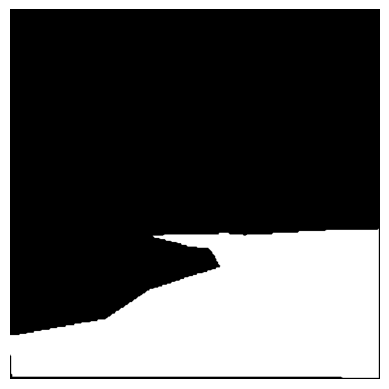

In [22]:
from evaluate import create_binary_mask
label_mask = create_binary_mask(resized_labels, imgsz)

plt.imshow(label_mask, cmap="gray")
_ = plt.axis("off")

In [23]:
import torch
from torchmetrics.detection.mean_ap import MeanAveragePrecision


# Convert to tensors and add batch/channel dimensions
preds = torch.tensor(mask * 1, dtype=torch.uint8).unsqueeze(0)      # shape: [1, 1, H, W]
target = torch.tensor(label_mask, dtype=torch.uint8).unsqueeze(0)

# Initialize metric
metric = MeanAveragePrecision(iou_type="segm")  # for segmentation-style masks

# Format inputs as COCO-style dicts
# Each item in the list is a dict for one image
predictions = [{
    "masks": preds.bool(),  # shape: [N, H, W], here N=1
    "scores": torch.tensor([1.0]),  # confidence score
    "labels": torch.tensor([1])     # class label
}]

targets = [{
    "masks": target.bool(),         # shape: [N, H, W], here N=1
    "labels": torch.tensor([1])     # class label
}]

# Update and compute
metric.update(predictions, targets)
results = metric.compute()

metric_names = {
    "map": "Mean Average Precision (mAP)",
    "map_50": "mAP at IoU=0.50",
    "map_75": "mAP at IoU=0.75",
    "map_small": "mAP for small objects",
    "map_medium": "mAP for medium objects",
    "map_large": "mAP for large objects",
    "mar_1": "Mean Average Recall @1 detection",
    "mar_10": "Mean Average Recall @10 detections",
    "mar_100": "Mean Average Recall @100 detections",
    "mar_small": "mAR for small objects",
    "mar_medium": "mAR for medium objects",
    "mar_large": "mAR for large objects",
    "map_per_class": "mAP per class",
    "mar_100_per_class": "mAR per class @100 detections",
    "classes": "Number of classes"
}

for key, value in results.items():
    label = metric_names.get(key, key)
    if isinstance(value, torch.Tensor):
        val = value.item()
        if val == -1.0:
            print(f"{label}: N/A")
        else:
            print(f"{label}: {val:.4f}")
    else:
        print(f"{label}: {value}")

Mean Average Precision (mAP): 0.5000
mAP at IoU=0.50: 1.0000
mAP at IoU=0.75: 0.0000
mAP for small objects: N/A
mAP for medium objects: N/A
mAP for large objects: 0.5000
Mean Average Recall @1 detection: 0.5000
Mean Average Recall @10 detections: 0.5000
Mean Average Recall @100 detections: 0.5000
mAR for small objects: N/A
mAR for medium objects: N/A
mAR for large objects: 0.5000
mAP per class: N/A
mAR per class @100 detections: N/A
Number of classes: 1.0000


In [24]:
from evaluate import compute_binary_metrics
metrics = compute_binary_metrics(preds, target)

for name, value in metrics.items():
    if isinstance(value, float):
        print(f"{name}: {value:.4f}")
    else:
        print(f"{name}: {value}")

True Positives (TP): 113007
True Negatives (TN): 254515
False Positives (FP): 39701
False Negatives (FN): 2377
Precision: 0.7400
Recall: 0.9794
Accuracy: 0.8973
Specificity: 0.8651
Sensitivity: 0.9794
F1 Score: 0.8430
Dice Coefficient: 0.8430
Intersection over Union (IoU): 0.7287


/project_antwerp/water-level-kul/pruning/evaluate.py:237: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred = torch.tensor(pred_mask, dtype=torch.bool).detach().clone()
/project_antwerp/water-level-kul/pruning/evaluate.py:238: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(label_mask, dtype=torch.bool).detach().clone()
